In [316]:
import numpy as np
from typing import Generator, Literal
import numpy.typing as npt
from dataclasses import dataclass
from functools import partial

import numpy as np
import numpy.typing as npt
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Helper functions


In [317]:
def vrow(vec: npt.NDArray) -> npt.NDArray:
    return vec.reshape(1, -1)

def confusion_matrix(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray[np.int32]:
    """Compute the confusion matrix for the given true and predicted labels

    Args:
        y_true (npt.NDArray): The true labels
        y_pred (npt.NDArray): The predicted labels

    Returns:
        npt.NDArray: The confusion matrix with the following structure:
            [[TN, FP],
             [FN, TP]]
    """
    return np.array(
        [
            [
                np.sum(np.logical_and(y_true == 0, y_pred == 0)),
                np.sum(np.logical_and(y_true == 0, y_pred == 1)),
            ],
            [
                np.sum(np.logical_and(y_true == 1, y_pred == 0)),
                np.sum(np.logical_and(y_true == 1, y_pred == 1)),
            ],
        ]
    )


def yield_confusion_matrices(
    y_true: npt.NDArray, thresholds: npt.NDArray
) -> Generator[npt.NDArray[np.int32], None, None]:
    indices = np.argsort(thresholds)
    ts = thresholds[indices]
    sorted_y_val = y_true[indices]

    y_pred = np.ones_like(y_true)

    TN = 0
    TP = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    FP = len(y_true) - TP
    FN = 0

    for i in range(1, len(ts)):
        y_pred[i - 1] = 0

        if sorted_y_val[i - 1] == 1:
            TP -= 1
            FN += 1
        else:
            FP -= 1
            TN += 1

        yield np.array([[TN, FP], [FN, TP]])


def optimal_bayes_threshold(pi: float, C_fn: float, C_fp: float) -> float:
    return -np.log((pi * C_fn) / ((1 - pi) * C_fp))


def effective_prior(pi_T: float, C_fn: float, C_fp: float) -> float:
    return (pi_T * C_fn) / (pi_T * C_fn + (1 - pi_T) * C_fp)


def dcf(
    llr: npt.NDArray,
    y_val: npt.NDArray,
    pi: float,
    Cf_n: float,
    Cf_p: float,
    strategy: Literal["optimal"] | Literal["min"] | Literal["manual"],
    normalize=True,
    threshold=0.0,
) -> float:
    """
    Compute the Detection Cost Function (DCF) for the given data and priors.

    Args:
        llr (NDArray): The log-likelihood ratio values.
        y_val (NDArray): The true labels.
        pi (float): The prior probability of a genuine sample.
        Cf_n (float): The cost of false negative.
        Cf_p (float): The cost of false positive.
        strategy (
            Literal["optimal"]
            | Literal["min"]
            | Literal["manual"],
        ): The threshold strategy to use, either "optimal", "min", or "manual".
            Use "optimal" to compute the optimal threshold, "min" to compute the
            minimum DCF value, and "manual" to use the given threshold.
        normalize (bool, optional): Whether to normalize the DCF value.
            Defaults to False.
        threshold (float, optional): The threshold to use if strategy is "manual".
            Does not have any effect if strategy is not "manual". Defaults to 0.0.

    Returns:
        float: The DCF value.
    """

    if strategy == "min":
        # Returns the minimum DCF value calculated over all the possible
        # threhsolds (taken from the log likelihood ratios)
        return min(
            [
                (
                    pi * (cm[1, 0] / cm[1].sum()) * Cf_n
                    + (1 - pi) * (cm[0, 1] / cm[0].sum()) * Cf_p
                )
                / (min(pi * Cf_n, (1 - pi) * Cf_p) if normalize else 1)
                for cm in yield_confusion_matrices(y_val, llr)
            ]
        )
    else:
        threshold = (
            optimal_bayes_threshold(pi, Cf_n, Cf_p)
            if strategy == "optimal"
            else threshold  # if strategy == "manual"
        )

        y_pred = llr > threshold

        cm = confusion_matrix(y_val, y_pred)

        P_fn = cm[1, 0] / cm[1].sum()
        P_fp = cm[0, 1] / cm[0].sum()

        return (pi * P_fn * Cf_n + (1 - pi) * P_fp * Cf_p) / (
            # Normalize the DCF value by dividing it by the best of the two
            # dummy systems: the one that always accepts a test segment and
            # the one that always rejects it.
            min(pi * Cf_n, (1 - pi) * Cf_p)
            if normalize
            else 1  # If normalization is not required, return the raw DCF value
        )


# Load the data


In [318]:
eval_labels = np.load("data/eval_labels.npy")
eval_scores_1 = np.load("data/eval_scores_1.npy")
eval_scores_2 = np.load("data/eval_scores_2.npy")
labels = np.load("data/labels.npy")
scores_1 = np.load("data/scores_1.npy")
scores_2 = np.load("data/scores_2.npy")

# Initial analysis


In [319]:
PRIOR = 0.2

## System 1


In [320]:
min_dcf_1 = dcf(scores_1, labels, PRIOR, 1, 1, "min")
act_dcf_1 = dcf(scores_1, labels, PRIOR, 1, 1, "optimal")

print(f"MinDCF for system 1: {min_dcf_1}")
print(f"ActDCF for system 1: {act_dcf_1}")

MinDCF for system 1: 0.20428671869296186
ActDCF for system 1: 0.29772502472799206


## System 2


In [321]:
min_dcf_2 = dcf(scores_2, labels, PRIOR, 1, 1, "min")
act_dcf_2 = dcf(scores_2, labels, PRIOR, 1, 1, "optimal")

print(f"MinDCF for system 2: {min_dcf_2}")
print(f"ActDCF for system 2: {act_dcf_2}")

MinDCF for system 2: 0.31056257807194676
ActDCF for system 2: 0.3280816978854441


## Plot the Bayes Error plots


In [322]:
def bayes_plot(scores, labels, left = -3, right = 3, npts = 21):
    effPriorLogOdds = np.linspace(left, right, npts)
    effPriors = 1.0 / (1.0 + np.exp(-effPriorLogOdds))

    act_dcf = []
    min_dcf = []
    
    for effPrior in effPriors:
        act_dcf.append(dcf(scores, labels, effPrior, 1, 1, "optimal"))
        min_dcf.append(dcf(scores, labels, effPrior, 1, 1, "min"))
        
    return effPriorLogOdds, act_dcf, min_dcf

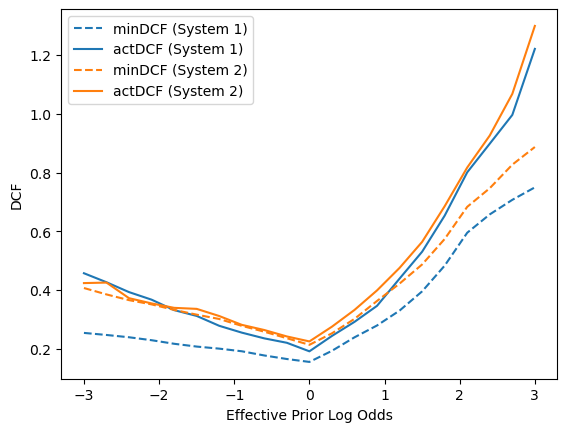

In [323]:
plt.figure()
logOdds, act_dcf, min_dcf = bayes_plot(scores_1, labels)
plt.plot(logOdds, min_dcf, color='C0', linestyle='--', label = 'minDCF (System 1)')
plt.plot(logOdds, act_dcf, color='C0', linestyle='-', label = 'actDCF (System 1)')

logOdds, act_dcf, min_dcf = bayes_plot(scores_2, labels)
plt.plot(logOdds, min_dcf, color='C1', linestyle='--', label = 'minDCF (System 2)')
plt.plot(logOdds, act_dcf, color='C1', linestyle='-', label = 'actDCF (System 2)')

plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()


# Calibration - Single-fold approach


## Split the set into two partitions


In [324]:
SCAL1, SVAL1 = scores_1[::3], np.hstack([scores_1[1::3], scores_1[2::3]])
SCAL2, SVAL2 = scores_2[::3], np.hstack([scores_2[1::3], scores_2[2::3]])
LCAL, LVAL = labels[::3], np.hstack([labels[1::3], labels[2::3]])

## Re-evaluate the Bayes Error


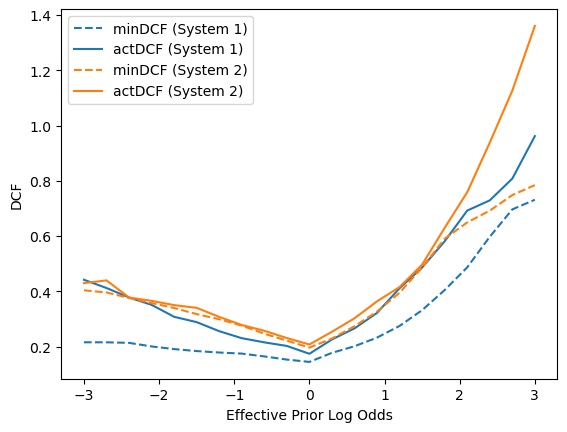

In [325]:
plt.figure()

logOdds, act_dcf, min_dcf = bayes_plot(SVAL1, LVAL)
plt.plot(logOdds, min_dcf, color='C0', linestyle='--', label = 'minDCF (System 1)')
plt.plot(logOdds, act_dcf, color='C0', linestyle='-', label = 'actDCF (System 1)')


logOdds, act_dcf, min_dcf = bayes_plot(SVAL2, LVAL)
plt.plot(logOdds, min_dcf, color='C1', linestyle='--', label = 'minDCF (System 2)')
plt.plot(logOdds, act_dcf, color='C1', linestyle='-', label = 'actDCF (System 2)')

plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()


## Calibrate the Systems


### Logistic Regression


In [326]:
@dataclass
class LogisticRegression:
    X_train: npt.NDArray
    y_train: npt.NDArray
    X_val: npt.NDArray
    y_val: npt.NDArray

    def train(self, l: float, prior: float, prior_weighted: bool = False):
        """
        Train the logistic regression classifier using the training data and the
        specified hyperparameters.

        Args:
            l (float): the regularization hyperparameter
            prior (float): the prior probability of the positive class
            prior_weighted (bool, optional): if True, the prior-weighted logistic
                regression objective is used, otherwise the standard logistic
                regression objective is used. Defaults to False.

        Returns:
            float: the value of the objective function at the optimal point
        """

        self.__prior_weighted = prior_weighted
        self.__prior = prior

        log_reg = partial(
            self.logreg_obj,
            approx_grad=True,
            DTR=self.X_train,
            LTR=self.y_train,
            l=l,
            prior=prior if prior_weighted else None,
        )

        x, f, _ = opt.fmin_l_bfgs_b(
            log_reg,
            np.zeros(self.X_train.shape[0] + 1),
            approx_grad=True,
        )

        w, b = x[:-1], x[-1]

        self.__S = w @ self.X_val + b

        return f

    @property
    def log_likelihood_ratio(self) -> npt.NDArray:
        """
        Log likelihood ratio of the classifier.
        """

        if self.__prior_weighted:
            return self.__S.ravel() - np.log(self.__prior / (1 - self.__prior))
        else:
            pi_emp = np.mean(self.y_train)  # Fractions of samples of class 1
            return self.__S.ravel() - np.log(pi_emp / (1 - pi_emp))

    @property
    def error_rate(self) -> float:
        """
        Error rate measure of the classifier.
        """

        LP = self.__S > 0
        return np.mean(LP != self.y_val)

    @staticmethod
    def logreg_obj(
        v: npt.NDArray[np.float64],
        *,
        prior: float | None,
        approx_grad: bool,
        DTR: npt.NDArray[np.float64],
        LTR: npt.NDArray[np.int64],
        l: float,
    ) -> tuple[float, npt.NDArray[np.float64]] | float:
        """
        Logistic Regression Objective Function

        Args:
            v (npt.NDArray[np.float64]): the vector of parameters
            prior (float | None): if not None, the prior probability of the positive
                class, computes the prior-weighted logistic regression objective
            approx_grad (bool): if True, only the result to the objective function
                is returned, if False, the gradient is also returned
            DTR (npt.NDArray[np.float64]): the training data
            LTR (npt.NDArray[np.int64]): the training labels
            l (float): the regularization hyperparameter

        Returns:
            tuple[float, npt.NDArray[np.float64]] | float: the value of the
                objective function and its gradient if approx_grad is False,
                otherwise only the value of the objective function
        """
        # This function wraps the real implementation to manage etheroegeneous
        # return types in the numba.jit compiled function
        result = LogisticRegression.__logreg_obj(
            v,
            prior=prior,
            approx_grad=approx_grad,
            DTR=DTR,
            LTR=LTR,
            l=l,
        )

        if approx_grad:
            return result[0]

        return result  # type: ignore

    @staticmethod
    def __logreg_obj(
        v: npt.NDArray[np.float64],
        *,
        prior: float | None,
        approx_grad: bool,
        DTR: npt.NDArray[np.float64],
        LTR: npt.NDArray[np.int64],
        l: float,
    ) -> tuple[float, npt.NDArray[np.float64] | None]:
        if v.shape[0] != (DTR.shape[0] + 1):
            raise ValueError(
                "The vector of parameters has the wrong shape, expected (n,) where"
                "n is the number of features in the training data."
            )

        w, b = v[:-1], v[-1]
        ZTR = 2 * LTR - 1
        S = (w @ np.ascontiguousarray(DTR) + b).ravel()
        G = -ZTR / (1 + np.exp(ZTR * S))

        if prior is not None:
            n_T = np.sum(LTR == 1)
            n_F = len(LTR) - n_T

            weights = np.where(LTR == 1, prior / n_T, (1 - prior) / n_F)
        else:  # Uniform weights, no slow down after jit compilation
            weights = np.ones_like(LTR) / len(LTR)

        # Logistic regression objective function,
        # J(w, b) = λ/2 * ||w||² + (1/n) ∑_{i=1}^{n} ξᵢ log(1 + exp(-zᵢ(wᵀxᵢ + b)),
        # where ξᵢ = πᴛ / nᴛ if zᵢ = 1, otherwise ξᵢ = (1 - πᴛ) / nꜰ if zᵢ = -1 when
        # prior-weighted logistic regression objective is used, otherwise
        # J(w, b) = λ/2 * ||w||² + (1/n) ∑_{i=1}^{n} log(1 + exp(-zᵢ(wᵀxᵢ + b)),
        # where zᵢ = 1 if cᵢ = 1, otherwise zᵢ = -1 if cᵢ = 0 (i.e. zᵢ = 2cᵢ - 1)
        f = l / 2 * np.linalg.norm(w) ** 2 + np.sum(weights * np.logaddexp(0, -ZTR * S))

        if not approx_grad:
            # fmt: off
            vgrad = np.array(
                [
                    # Gradient with respect to w, ∇wJ = λw + ∑_{i=1}^{n} ξᵢGᵢxᵢ if
                    # prior-weighted logistic regression objective is used,
                    # otherwise ∇wJ = λw + (1/n)∑_{i=1}^{n} Gᵢxᵢ
                    *(l * w + np.sum(weights * vrow(G) * DTR)),

                    # Gradient with respect to b, ∇bJ = ∑_{i=1}^{n} ξᵢGᵢ if
                    # prior-weighted logistic regression objective is used,
                    # otherwise ∇bJ = (1/n)∑_{i=1}^{n} Gᵢ
                    np.sum(weights * G),
                ]
            )
            # fmt: on
            return f, vgrad

        return f, None


### System 1


#### Calibration validation set

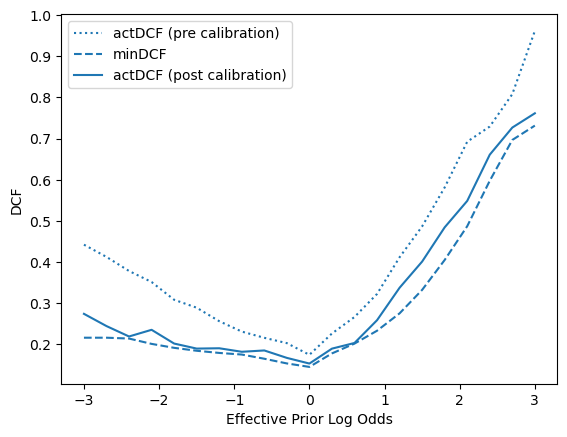

In [327]:
# Save non calibrated scores for reference
logOdds, act_dcf, min_dcf = bayes_plot(SVAL1, LVAL)

logReg = LogisticRegression(vrow(SCAL1), LCAL, vrow(SVAL1), LVAL)

logReg.train(0, PRIOR, prior_weighted=True)

calibrated_scores = logReg.log_likelihood_ratio

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, LVAL)

plt.figure()
plt.plot(logOdds, act_dcf, color='C0', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C0', linestyle='--', label = 'minDCF')
plt.plot(logOdds_cal, act_dcf_cal, color='C0', linestyle='-', label = 'actDCF (post calibration)')
plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()

#### Evaluation set

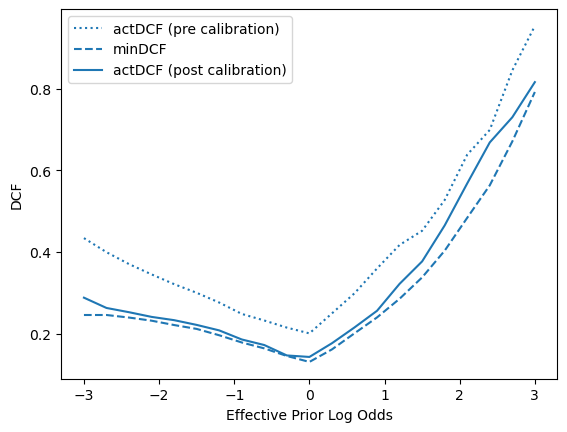

In [328]:
logOdds, act_dcf, min_dcf = bayes_plot(eval_scores_1, eval_labels)

logReg = LogisticRegression(vrow(SCAL1), LCAL, vrow(eval_scores_1), eval_labels)

logReg.train(0, PRIOR, prior_weighted=True)

calibrated_scores = logReg.log_likelihood_ratio

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, eval_labels)

plt.figure()
plt.plot(logOdds, act_dcf, color='C0', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C0', linestyle='--', label = 'minDCF')
plt.plot(logOdds_cal, act_dcf_cal, color='C0', linestyle='-', label = 'actDCF (post calibration)')
plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()

### System 2

#### Calibration validation set

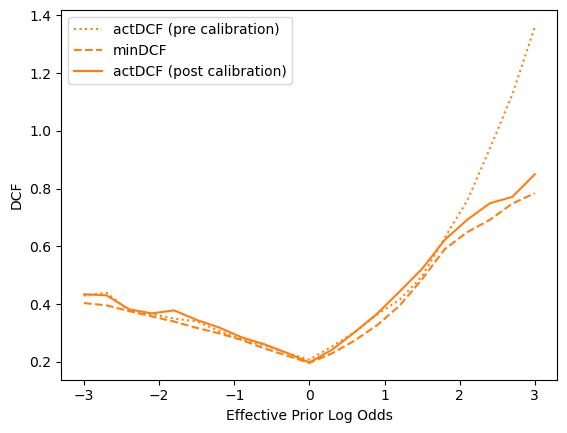

In [329]:
# Save non calibrated scores for reference
logOdds, act_dcf, min_dcf = bayes_plot(SVAL2, LVAL)

logReg = LogisticRegression(vrow(SCAL2), LCAL, vrow(SVAL2), LVAL)

logReg.train(0, PRIOR, prior_weighted=True)

calibrated_scores = logReg.log_likelihood_ratio

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, LVAL)

plt.figure()
plt.plot(logOdds, act_dcf, color='C1', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C1', linestyle='--', label = 'minDCF')
plt.plot(logOdds_cal, act_dcf_cal, color='C1', linestyle='-', label = 'actDCF (post calibration)')
plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()

#### Evaluation set

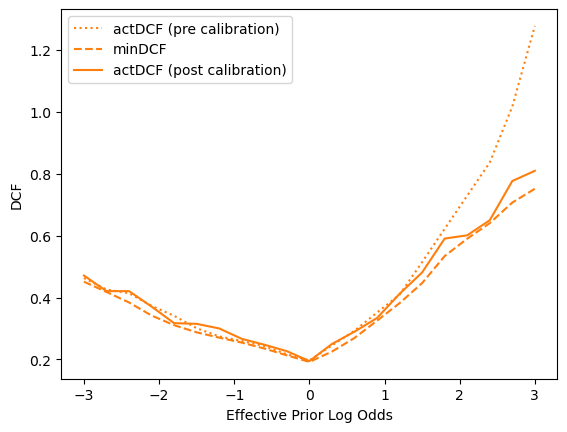

In [330]:
# Save non calibrated scores for reference
logOdds, act_dcf, min_dcf = bayes_plot(eval_scores_2, eval_labels)

logReg = LogisticRegression(vrow(SCAL2), LCAL, vrow(eval_scores_2), eval_labels)

logReg.train(0, PRIOR, prior_weighted=True)

calibrated_scores = logReg.log_likelihood_ratio

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, eval_labels)

plt.figure()
plt.plot(logOdds, act_dcf, color='C1', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C1', linestyle='--', label = 'minDCF')
plt.plot(logOdds_cal, act_dcf_cal, color='C1', linestyle='-', label = 'actDCF (post calibration)')
plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()

# K-fold approach

In [331]:
K = 5

In [332]:
# Extract i-th fold from a 1-D numpy array (as for the single fold case, we do
# not need to shuffle scores in this case, but it may be necessary if samples
# are sorted in peculiar ways to ensure that validation and calibration sets are
# independent and with similar characteristics)
def extract_train_val_folds_from_ary(X, idx):
    return np.hstack([X[jdx::K] for jdx in range(K) if jdx != idx]), X[idx::K]

## Validation set

### System 1

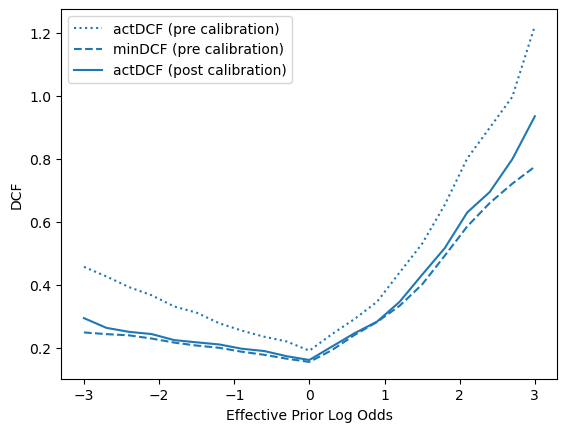

In [333]:
logOdds, act_dcf, min_dcf = bayes_plot(scores_1, labels)

calibrated_scores = []
calibrated_labels = []

for i in range(K):
    SCAL, SVAL = extract_train_val_folds_from_ary(scores_1, i)
    LCAL, LVAL = extract_train_val_folds_from_ary(labels, i)
    
    logReg = LogisticRegression(vrow(SCAL), LCAL, vrow(SVAL), LVAL)
    
    logReg.train(0, PRIOR, prior_weighted=True)
    
    calibrated_scores.append(logReg.log_likelihood_ratio)
    calibrated_labels.append(LVAL)
    
calibrated_scores = np.hstack(calibrated_scores)
calibrated_labels = np.hstack(calibrated_labels)

# Evaluate the performance of pooled scores

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, calibrated_labels)

plt.figure()
plt.plot(logOdds, act_dcf, color='C0', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C0', linestyle='--', label = 'minDCF (pre calibration)')
# NOTE: actDCF of the calibrated pooled scores MAY be lower than the global
# minDCF we computed earlier, since ache fold is calibrated on its own (thus
# it's as if we were estimating a possibly different threshold for each fold,
# whereas minDCF employs a single threshold for all scores)
plt.plot(logOdds_cal, act_dcf_cal, color='C0', linestyle='-', label = 'actDCF (post calibration)')

plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()


### System 2

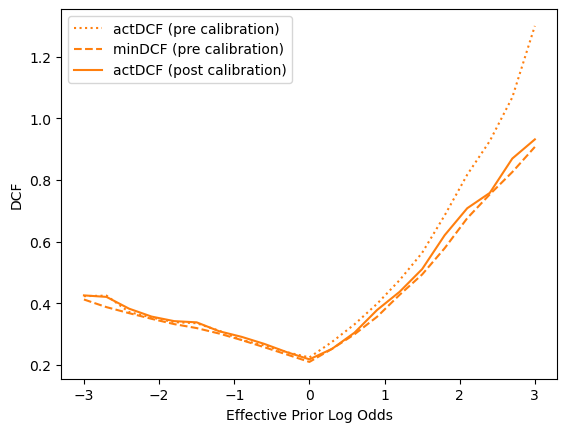

In [334]:
logOdds, act_dcf, min_dcf = bayes_plot(scores_2, labels)

calibrated_scores = []
calibrated_labels = []

for i in range(K):
    SCAL, SVAL = extract_train_val_folds_from_ary(scores_2, i)
    LCAL, LVAL = extract_train_val_folds_from_ary(labels, i)
    
    logReg = LogisticRegression(vrow(SCAL), LCAL, vrow(SVAL), LVAL)
    
    logReg.train(0, PRIOR, prior_weighted=True)
    
    calibrated_scores.append(logReg.log_likelihood_ratio)
    calibrated_labels.append(LVAL)
    
calibrated_scores = np.hstack(calibrated_scores)
calibrated_labels = np.hstack(calibrated_labels)

# Evaluate the performance of pooled scores

logOdds_cal, act_dcf_cal, min_dcf_cal = bayes_plot(calibrated_scores, calibrated_labels)

plt.figure()
plt.plot(logOdds, act_dcf, color='C1', linestyle=':', label = 'actDCF (pre calibration)')
plt.plot(logOdds_cal, min_dcf_cal, color='C1', linestyle='--', label = 'minDCF (pre calibration)')
# NOTE: actDCF of the calibrated pooled scores MAY be lower than the global
# minDCF we computed earlier, since ache fold is calibrated on its own (thus
# it's as if we were estimating a possibly different threshold for each fold,
# whereas minDCF employs a single threshold for all scores)
plt.plot(logOdds_cal, act_dcf_cal, color='C1', linestyle='-', label = 'actDCF (post calibration)')

plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()


# Fusion

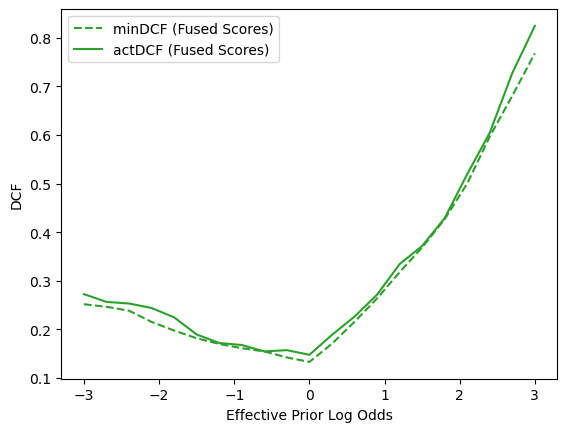

: 

In [337]:
fused_scores_cal = []
fused_labels_cal = []

for i in range(K):
    SCAL1, SVAL1 = extract_train_val_folds_from_ary(scores_1, i)
    SCAL2, SVAL2 = extract_train_val_folds_from_ary(scores_2, i)
    LCAL, LVAL = extract_train_val_folds_from_ary(labels, i)
    
    SCAL = np.vstack([SCAL1, SCAL2])
    SVAL = np.vstack([SVAL1, SVAL2])
    
    logReg = LogisticRegression(SCAL, LCAL, SVAL, LVAL)
    
    logReg.train(0, PRIOR, prior_weighted=True)
    
    fused_scores_cal.append(logReg.log_likelihood_ratio)
    fused_labels_cal.append(LVAL)
    
fused_scores_cal = np.hstack(fused_scores_cal)
fused_labels_cal = np.hstack(fused_labels_cal)

plt.figure()
logOdds, act_dcf, min_dcf = bayes_plot(fused_scores_cal, fused_labels_cal)
plt.plot(logOdds, min_dcf, color='C2', linestyle='--', label = 'minDCF (Fused Scores)')
plt.plot(logOdds, act_dcf, color='C2', linestyle='-', label = 'actDCF (Fused Scores)')
plt.xlabel('Effective Prior Log Odds')
plt.ylabel('DCF')
plt.legend()
plt.show()